# Project: Ubiquitous Computing Project 2

Date: 05.2021

Authors: 
 * Rayan Armani [rarmani@ethz.ch]
 * Massimo Albarello [malbarello@ethz.ch]

## 0. Importing data and necessary libraries


In [1]:
import pickle as pickle 
import numpy as np
import pandas as pd
import time
from scipy import signal, stats
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, pearsonr
from neurokit2 import eda_phasic, eda_peaks
# from tqdm.notebook import tqdm
import tsfel
import warnings; warnings.simplefilter('ignore')


plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


## 1. Feature extraction and data analysis

### 1.1 ECG

#### a) Plotting the PSD
The Lead I ECG signal is the difference between the sensor measurements of the left and right arms. To find its Power Spectral Density we use Welch's method such as in Abadi et al.  

References:
* [scipy.signal.welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)
* [Mojtaba Khomami Abadi, Ramanathan Subramanian, Seyed Mostafa Kia, Paolo Avesani, Ioannis Patras, and Nicu Sebe. Decaf: Meg-based multimodal database for decoding affective physiological responses. *IEEE Transactions on Affective Computing*, 6(3):209–222, 2015 ](https://stefan.winkler.site/Publications/tac2015.pdf)

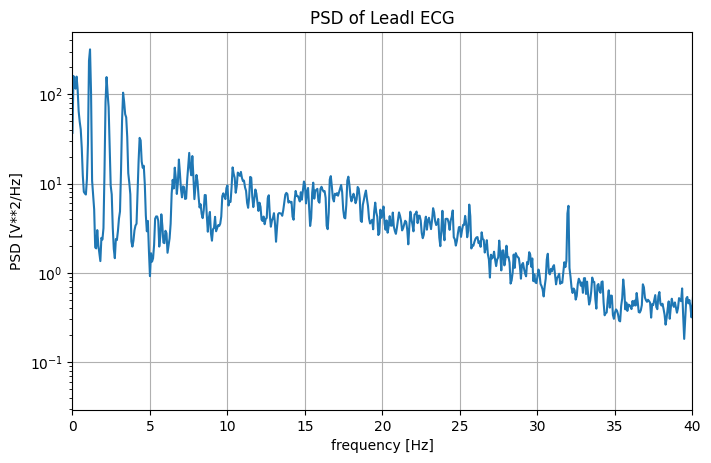

In [2]:
# Get data for the first patient
with open("ex2_recordings/participant_01.pkl", "rb") as f:
    particiapnt_01_data = pickle.load(f)
    
# Extract sampling frequency of ECG
ECG_freq = particiapnt_01_data["FS_ECG"]

# Extract Lead I ECG (left_hand - right hand) signal of the first participant watching clip 1
raw_ECG_p1 = np.array(particiapnt_01_data["recordings"][1]["ECG"])

lead1_ecg_p1= np.array(raw_ECG_p1[:,1]-raw_ECG_p1[:,2])

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=lead1_ecg_p1, fs= ECG_freq, nperseg = 15*ECG_freq, noverlap= 10*ECG_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of LeadI ECG')
plt.grid(True)
plt.show()


#### b) Signal filtering

The raw Lead I ECG is inherently noisy, as shown by the presence of high frequency components as revealed in the PSD. Features of interest in an ECG however, are in the lower frequency ranges. From the PSD plot, we can infer that the signal's most significant components lie in the [0-20Hz] range. As such we can design a low pass filter to remove noise components with frequencies above 20Hz, using scipy's implementation of a Butterworth filter. When we plot the results from a simple low pass filter, we notice the baseline is not stable. To reduce the effect of a wandering baseline, we add a high pass filter at 2Hz. We can combine both filters in a bandapss filter over [4-20Hz] 
Notes: **most papers I reaad mentioned filtering with a cutoff at 20Hz ex: https://www.hindawi.com/journals/cmmm/2015/453214/

References: 
* [scipy.signal.butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)
* [scipy repository on github](https://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass)


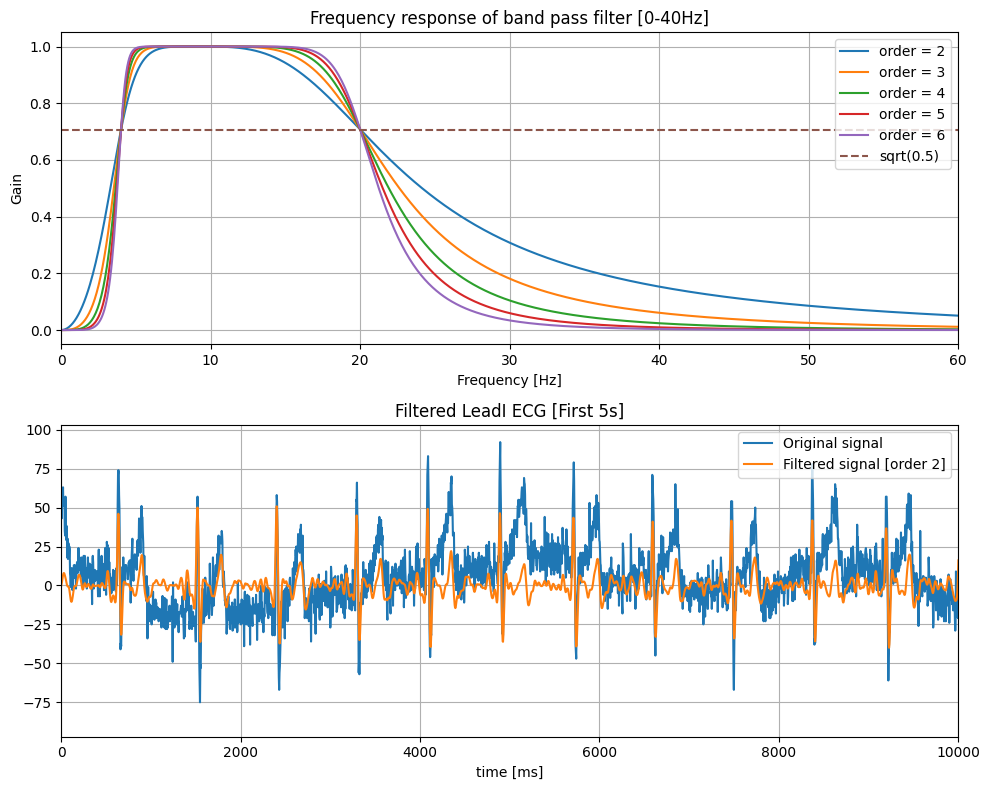

In [3]:

# Low pass filter definition functions
def butter_bandpass(lowcut, highcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order,[low,high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y
# Low pass filter implementation
# Parameters
lowcut = 4 #[Hz]
highcut = 20
fs = ECG_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,60)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-40Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 2
# Apply the low pass filer to the lead I ECG filter
filtered_lead1_ecg_p1 = butter_bandpass_filter(lead1_ecg_p1,lowcut, highcut, fs, order)

# Get time 
t = np.array(raw_ECG_p1[:,0]) - raw_ECG_p1[0,0] #[ms]

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t,lead1_ecg_p1, label='Original signal')
ax[1].plot(t,filtered_lead1_ecg_p1, label='Filtered signal [order %d]' %order)
ax[1].set_xlabel('time [ms]')
ax[1].set_xlim(0,10000)
ax[1].grid(True)
ax[1].set_title('Filtered LeadI ECG [First 5s]') 
ax[1].legend(loc='upper right')
plt.tight_layout()
plt.show()


#### c) Artifact detection 

We are looking for the percentage of recorded ECG data that contains artifacts over the complete dataset (last 50 s for each clip). This can be computed by taking the ratio between the sum of the flagged intervals and the accumulated time of the ECG recordings. 
 

References: 

Artifact found in clip 1 of participant 2
Indicices of the artifacts: [31 32 37 38 41 42 44 45]
Grouped indices: [(31, 2), (37, 2), (41, 2), (44, 2)]
Interpolating from 875.0 to 902.34375
Adding interpolation points: [884.11458333 893.22916667]
Interpolating from 847.65625 to 824.21875
Adding interpolation points: [839.84375 832.03125]
Interpolating from 812.5 to 812.5
Adding interpolation points: [812.5 812.5]
Interpolating from 812.5 to 816.40625
Adding interpolation points: [813.80208333 815.10416667]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


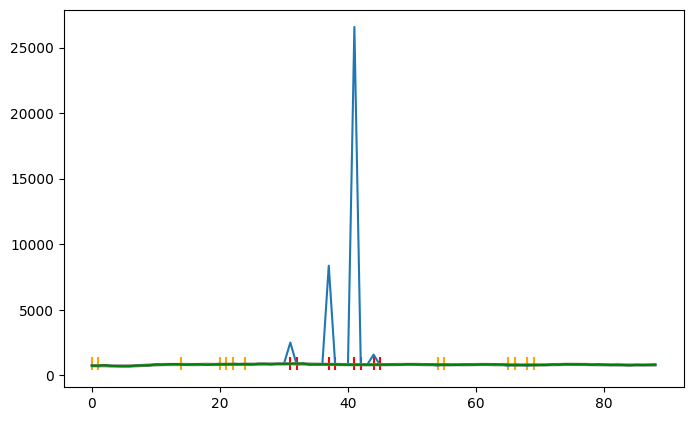

Artifact found in clip 2 of participant 2
Indicices of the artifacts: [1 2]
Grouped indices: [(1, 2)]
Interpolating from 761.71875 to 703.125
Adding interpolation points: [742.1875  722.65625]
Found one value out of bounds
Found one value out of bounds


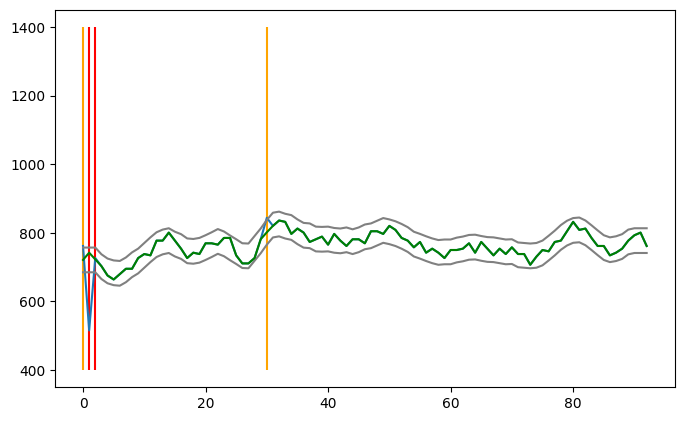

Artifact found in clip 7 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 519.53125 to 722.65625
Adding interpolation points: [621.09375]
Found one value out of bounds
Found one value out of bounds


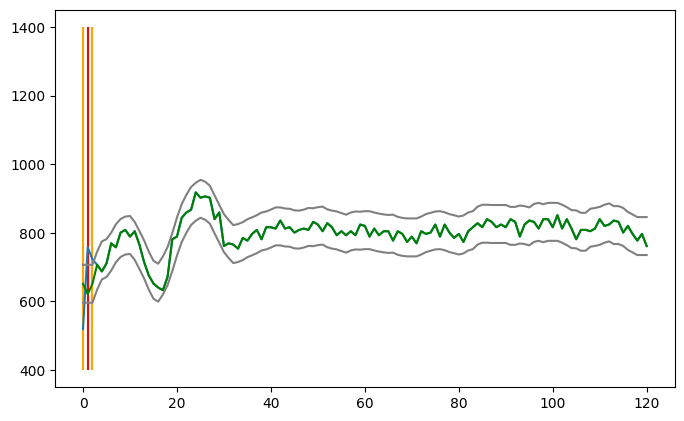

Artifact found in clip 11 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 539.0625 to 710.9375
Adding interpolation points: [625.]
Found one value out of bounds
Found one value out of bounds


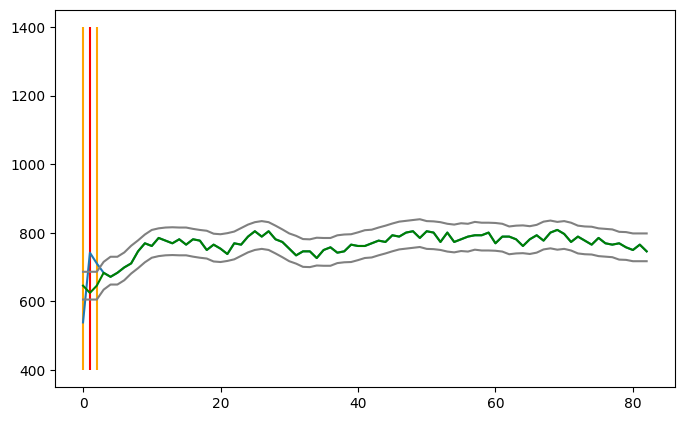

Artifact found in clip 13 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 527.34375 to 714.84375
Adding interpolation points: [621.09375]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


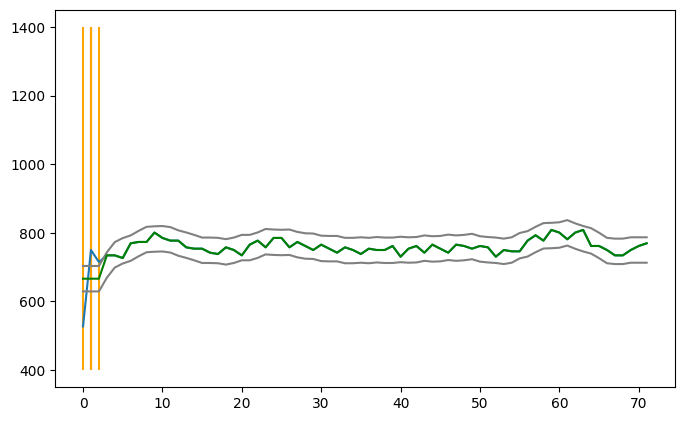

Artifact found in clip 16 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 542.96875 to 714.84375
Adding interpolation points: [628.90625]
Found one value out of bounds
Found one value out of bounds


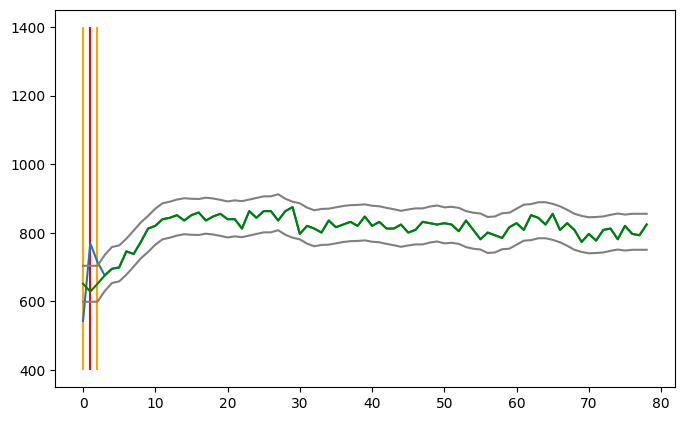

Artifact found in clip 17 of participant 2
Indicices of the artifacts: [7 8 9]
Grouped indices: [(7, 3)]
Interpolating from 812.5 to 820.3125
Adding interpolation points: [814.453125 816.40625  818.359375]


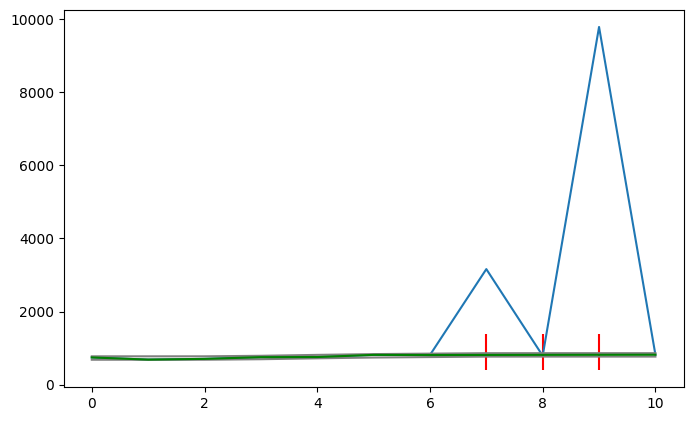

Artifact found in clip 18 of participant 2
Indicices of the artifacts: [ 1 81 82]
Grouped indices: [(1, 1), (81, 2)]
Interpolating from 519.53125 to 750.0
Adding interpolation points: [634.765625]
Interpolating from 820.3125 to 769.53125
Adding interpolation points: [803.38541667 786.45833333]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


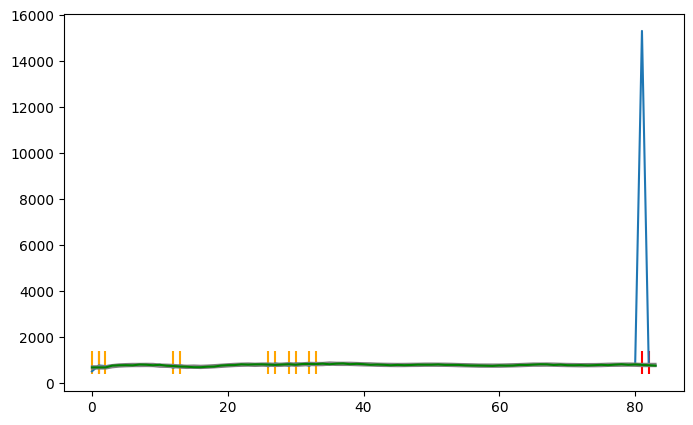

Artifact found in clip 19 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 503.90625 to 695.3125
Adding interpolation points: [599.609375]
Found one value out of bounds
Found one value out of bounds


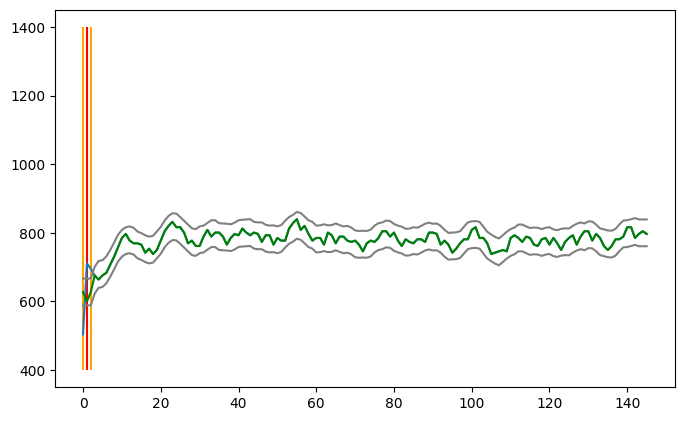

Artifact found in clip 25 of participant 2
Indicices of the artifacts: [ 1 17 18 21 22 27 28 29 30 31 32]
Grouped indices: [(1, 1), (17, 2), (21, 2), (27, 6)]
Interpolating from 535.15625 to 750.0
Adding interpolation points: [642.578125]
Interpolating from 796.875 to 894.53125
Adding interpolation points: [829.42708333 861.97916667]
Interpolating from 855.46875 to 855.46875
Adding interpolation points: [855.46875 855.46875]
Interpolating from 851.5625 to 792.96875
Adding interpolation points: [843.19196429 834.82142857 826.45089286 818.08035714 809.70982143
 801.33928571]
Found one value out of bounds


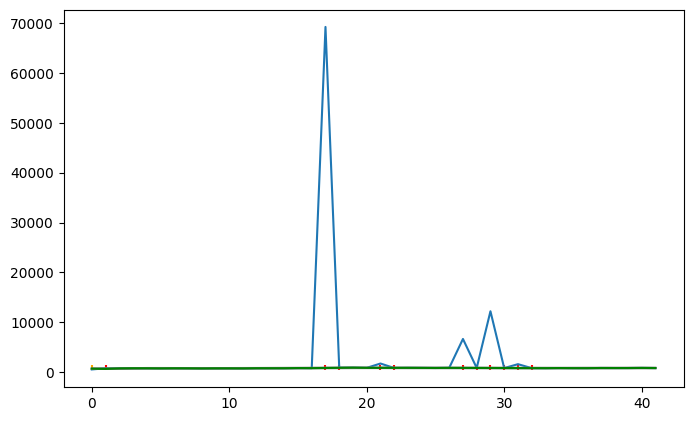

Artifact found in clip 26 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 570.3125 to 707.03125
Adding interpolation points: [638.671875]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


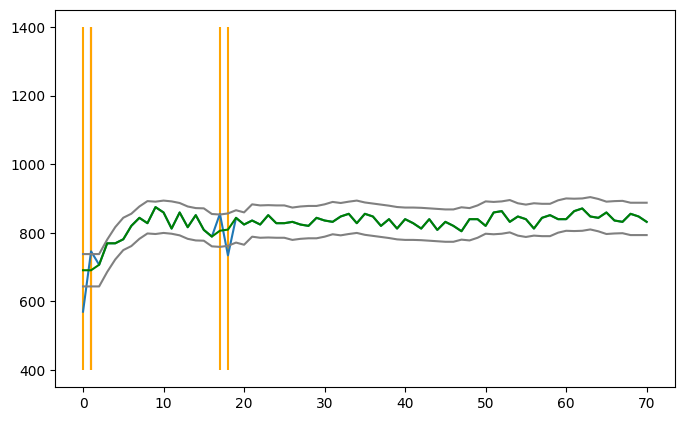

Artifact found in clip 28 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 535.15625 to 792.96875
Adding interpolation points: [664.0625]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


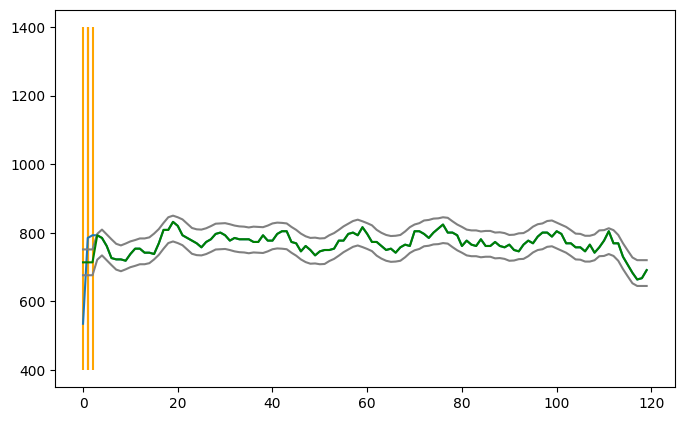

Artifact found in clip 34 of participant 2
Indicices of the artifacts: [2 3 5 6 7]
Grouped indices: [(2, 2), (5, 3)]
Interpolating from 507.8125 to 718.75
Adding interpolation points: [578.125  648.4375]
Interpolating from 718.75 to 687.5
Adding interpolation points: [710.9375 703.125  695.3125]
Found one value out of bounds
Found one value out of bounds


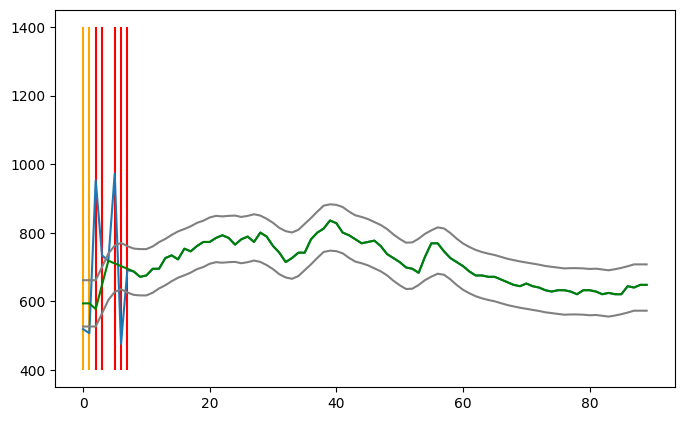

Artifact found in clip 35 of participant 2
Indicices of the artifacts: [1 2 3]
Grouped indices: [(1, 3)]
Interpolating from 558.59375 to 730.46875
Adding interpolation points: [601.5625  644.53125 687.5    ]
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds
Found one value out of bounds


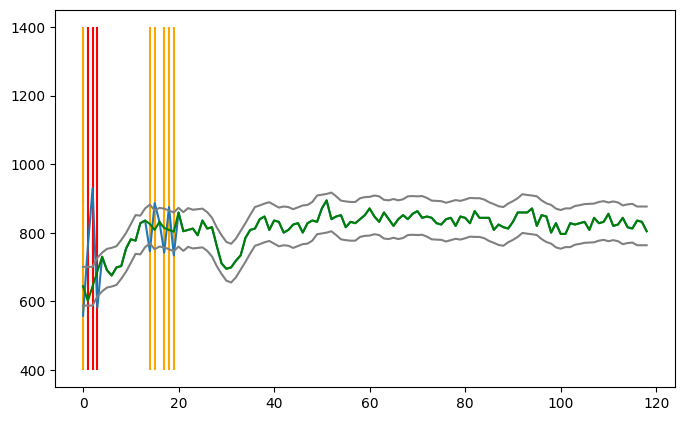

Artifact found in clip 36 of participant 2
Indicices of the artifacts: [1]
Grouped indices: [(1, 1)]
Interpolating from 527.34375 to 691.40625
Adding interpolation points: [609.375]
Found one value out of bounds
Found one value out of bounds


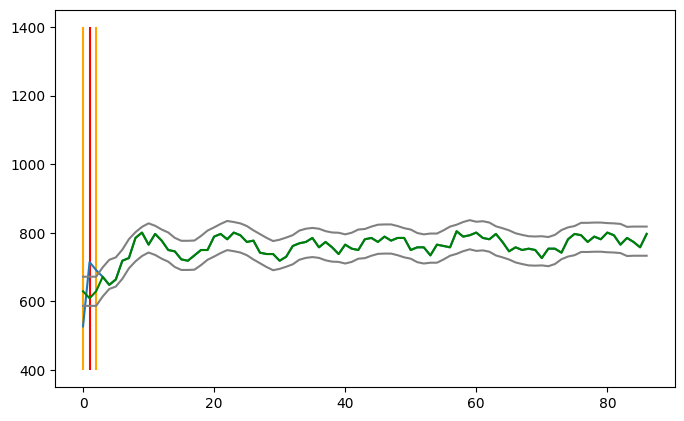

Percentage of ECG data having artifacts: 10.142578%


In [40]:
# Utility functions for artifact detection algorithm
def get_RRI(filtered_ecg_signal, fs):
    '''
    Returns an array containing the RR peak intervals for a signal, in ms. 
    '''
    # # Compute the derivative og the filtered signal
    # diff = np.diff(filtered_ecg_signal) 

    # # Compute the square of the derivative to evidence the peaks in the signal
    # squared = diff*diff
    squared = filtered_ecg_signal
    # Use scipy find RR peaks (hand tuned)
    peaks, _ = signal.find_peaks(squared, height= 20, threshold= None, distance=120, prominence= 10)
    RRI = np.diff(peaks)
    RRI_ms = RRI*1000/fs
    
    return RRI_ms, peaks

def get_CBD(RRI):
    '''
    Return the Criterion Beat Difference given an array of RR peaks intervals. Based on the work of Hovsepian et al. 
    '''
    # Make sure RRI interval is not all empty
    if RRI.size ==0:
        Q1 = np.NaN
        Q2 = np.NaN
        Q3 = np.NaN

    else:
        Q1 = np.nanpercentile(RRI, 25)
        Q2 = np.nanpercentile(RRI, 50)
        Q3 = np.nanpercentile(RRI, 75)

    QD = (Q3-Q1)/2.0 # Quartile Deviation
    MAD = (Q2-2.9*QD)/3.0
    MED = 3.32*QD

    CBD =(MAD+MED)/2.0
    return CBD

def detect_artifacts(RRI, CBD):
    '''
    Detects artifacts in ECG signal. Input needs to be filtered ecg
    '''
    has_artifacts = False
    last_valid_RRI = 0

    valid_RRI_indices = np.ones((1,len(RRI))).reshape(-1,1)
    for i in range(1,len(RRI)-1):
        if RRI[i-1] >= 300 and RRI[i-1]<=2000:
            if abs(RRI[i]-RRI[i-1])<=CBD:
                valid_RRI_indices[i]=1
            else: 
                valid_RRI_indices[i]=0
        else:
            if abs(RRI[i]-last_valid_RRI)<=CBD:
                valid_RRI_indices[i]=1
            else:
                if abs(RRI[i]-RRI[i-1])<=CBD and abs(RRI[i]-RRI[i+1])<=CBD:
                    valid_RRI_indices[i]=1
                else:
                    valid_RRI_indices[i]=0
                    

    # Count artifacts
    n_artifacts = len(RRI)-np.sum(valid_RRI_indices)
    if n_artifacts > 0:
        has_artifacts = True
    return has_artifacts, valid_RRI_indices

def removeArtifacts(rri, artifact_indices):

    print('\nArtifact found in clip {} of participant {}'. format(artifactClip, artifactPart))
    print('Indicices of the artifacts: {}'.format(artifact_indices))

    groupedIndices = []
    groupStart = 0
    while groupStart < len(artifact_indices):
        groupCount = 1 
        groupEnd = groupStart + 1
        while groupEnd < len(artifact_indices) and artifact_indices[groupEnd] - artifact_indices[groupEnd-1] == 1:
            groupCount += 1
            groupEnd += 1
        groupedIndices.append((artifact_indices[groupStart], groupCount))
        groupStart = groupEnd
    print('Grouped indices: {}'.format(groupedIndices))
    cleanRRI = rri
    for group in groupedIndices:
        firstWrongInd = group[0]
        lastWrongInd = group[0] + group[1] - 1
        startInter = rri[firstWrongInd-1]
        endInter = rri[lastWrongInd+1]
        interPoints = np.linspace(startInter, endInter, group[1]+2)
        print('Interpolating from {} to {}'.format(startInter, endInter))
        print('Adding interpolation points: {}'.format(interPoints[1:-1]))
        for off, point in enumerate(interPoints[1:-1]):
            cleanRRI[firstWrongInd+off] = point

    # as we noticed that the artifact detector couldn't always detect the artifacts at the extremes of the RRI arrays, we decided to set the values out of the varying thresholds to the mean of the window corresponding to each value
    window_size = 5    # averaging over 5 inter beat inetervals, use a odd number as window_size
    numbers_series = pd.Series(cleanRRI)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    averages = moving_averages_list[window_size - 1:]
    for i in range(int((len(cleanRRI) - len(averages)) / 2)):   # make sure that window_size is an odd number !!!
        averages.insert(0, averages[0])
        averages.append(averages[-1])
    stdev = np.std(cleanRRI)
    upperThresh = averages + stdev
    lowerThresh = averages - stdev
    plt.plot(upperThresh, color='grey')
    plt.plot(lowerThresh, color='grey')
    for index, val in enumerate(cleanRRI):
        if val < lowerThresh[index] or val > upperThresh[index]:
            print('Found one value out of bounds')
            plt.vlines(index, 400, 1400, color='orange')
            cleanRRI[index] = averages[index]

    return cleanRRI

# Variables for percentage calculation
total_time = 0
total_artifact_time = 0
counter = 0

for i in range(1, 44):
    if i<=9:
        pn = "0"+str(i)
    else: 
        pn= str(i) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of ECG
        fs = participant_data["FS_ECG"]

        keys = participant_data["recordings"].keys()
        clip_ids = []
        for key in keys:
            clip_ids.append(key)

        artifactClip = -1
        artifactPart = -1
        # Extract ECG for each clip 
        for clip in clip_ids[:]:
            counter +=1
            raw_ECG= np.array(participant_data["recordings"][clip]["ECG"])

            # Get lead1 ECG signal
            lead1_ecg= np.array(raw_ECG[:,1]-raw_ECG[:,2])
            t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]

            # Filter ECG signal
            filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg,lowcut, highcut, fs, order)

            # Add the 50s to the total time
            total_time += 50*1000.0 #[ms]

            # Get RR peaks intervals
            RRI, peaks = get_RRI(filtered_lead1_ecg, fs)
    
            # Get Criterion beat interval for artifact detection
            CBD = get_CBD(RRI)

            # Check for artifacts
            artifact, idx = detect_artifacts(RRI, CBD)
            # print(idx[:,0])

            artifact_indices = []
            cleanRRI = []
            if artifact == True:
                artifactClip = clip
                artifactPart = i
                # Find the total time of flagged intervals
                artifact_indices = np.where(idx==0)[0]
                artifacts_time = np.sum(RRI[artifact_indices])

                # Add to the general flagged time counter
                total_artifact_time += artifacts_time
                
                plt.plot(RRI)
                for index in artifact_indices:
                    plt.vlines(index, 400, 1400, color='r')

                cleanRRI = removeArtifacts(RRI, artifact_indices)
                plt.plot(cleanRRI, color='g')
                plt.show()
                               
percentage = 100*(total_artifact_time/total_time)
print("Percentage of ECG data having artifacts: {:2f}%".format(percentage))


#### d) Feature extraction

References: 

In [60]:
#### Utils ####

def find_features(signal, fs, name, columnStart):
    # features = tsfel.time_series_features_extractor(cfg_file, signal, fs=fs, window_size=len(signal))    # Receives a time series sampled at 256 Hz, uses a window of length of the whole singla and extracts all features
    # print('Statistical measurements of: {}'.format(name))

    features = []
    features.append(stats.kurtosis(signal))
    features.append(np.mean(signal))
    features.append(stats.skew(signal))
    features.append(np.std(signal))
    
    # print("\nThe {} values have: \nkurtosis: {:.4f}\nmean: {:.4f}\nskewness: {:.4f}\nstandard deviation: {:.4f}".format(name, features[0], features[1], features[2], features[3]))

    tot = len(signal)
    count = 0
    for value in signal:
        if value < features[1] - features[3] or value > features[1] + features[3]:
            count += 1
    # print('The percentage of times the {} is more than a standard deviation away from the mean is: {:.2f}%'.format(item, count/tot))
    features.append(count/tot)

    for offset, feature in enumerate(features):
        # print('{}: {}'.format(feature, features[feature][0]))
        # featuresArray[countTot][columnStart+offset] = features[feature][0]
        featuresArray[countTot][columnStart+offset] = feature

    # plt.plot(filtered_lead1_ecg_p1)
    # plt.show()
    return features

def rangesPSD(f, psd):
    ranges = np.linspace(0, 2.4, 11)
    startIndex = 0
    endIndex = 0
    for off, range in enumerate(ranges[1:]):
        while f[endIndex] < range:
            endIndex += 1
        # print('[{}, {}]'.format(f[startIndex], f[endIndex]))
        avgPSD = np.mean(np.log(psd[startIndex:endIndex]))
        # print(avgPSD)
        featuresArray[countTot][featureStart[3]+off] = avgPSD
        startIndex = endIndex 

    ranges = np.linspace(0, 0.4, 5)
    startIndex = 0
    endIndex = 0
    for off, range in enumerate(ranges[1:]):
        while f[endIndex] < range:
            endIndex += 1
        # print('[{}, {}]'.format(f[startIndex], f[endIndex]))
        avgPSD = np.mean(psd[startIndex:endIndex])
        # print(avgPSD)
        featuresArray[countTot][featureStart[4]+off] = avgPSD
        startIndex = endIndex 

# how should we normalize the signal?
def normalizeSignal(signal):
    # return (signal - np.mean(signal))/np.std(signal)

    # max = np.max(signal)
    # min = np.min(signal)
    # return np.array([(value - min) / (max - min) for value in signal])

    return signal

Npartecipants = 44
NclipsPerParticipant = 36   
NclipsTot = Npartecipants * NclipsPerParticipant # 44 participants * 36 clips each (even invald ones which features are marked as NaN)
featuresName = ['IBIkurt', 'IBImean', 'IBIskew', 'IBIstdev', 'IBIout', 'HRVkurt', 'HRVmean', 'HRVskew', 'HRVstdev', 'HRVout', 'HRkurt', 'HRmean', 'HRskew', 'HRstdev', 'HRout', 'logPSD1', 'logPSD2', 'logPSD3', 'logPSD4', 'logPSD5', 'logPSD6', 'logPSD7', 'logPSD8', 'logPSD9', 'logPSD10', 'PSD1', 'PSD2', 'PSD3', 'PSD4']
featureStart = [2, 7, 12, 17, 27]   # contains the index of the column of featuresArray from which the parameters start
NaN = -9999.

# !!! features corresponding to not valid clips have value -9999, make sure to check for this value and not consider it !!!
featuresArray = np.full((NclipsTot, len(featuresName)+2), NaN)

# cfg_file = tsfel.get_features_by_domain("statistical")      # If no argument is passed retrieves all available features
# # print(cfg_file["statistical"].keys())

# for feature in cfg_file["statistical"].keys():
#     if feature != 'Mean'  and feature != 'Skewness' and feature != 'Standard deviation' and feature != 'Kurtosis':
#         cfg_file["statistical"][feature]["use"] = 'no'
#     else:
#         cfg_file["statistical"][feature]["use"] = 'yes'
#     # print('{}: {}'.format(feature, cfg_file["statistical"][feature]["use"]))

countTot = 0
for part in range(1, Npartecipants+1):
    # print('participant {}'.format(part))
    if part <= 9:
        pn = "0"+str(part)
    else: 
        pn = str(part) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of ECG
        fs = participant_data["FS_ECG"]

        # Clips
        keys = participant_data["recordings"].keys()
        clip_ids = []
        for key in keys:
            clip_ids.append(key)

        # Extract ECG for each clip 
        old_clip = 0
        for clip in clip_ids[:]:
            while clip - old_clip > 1:
                old_clip += 1
                # print('missing clip {}'.format(old_clip))
                featuresArray[countTot][0] = part
                featuresArray[countTot][1] = old_clip
                countTot += 1
            featuresArray[countTot][0] = part
            featuresArray[countTot][1] = clip

            # print(clip)
            # Get lead1 ECG signal
            raw_ECG = np.array(participant_data["recordings"][clip]["ECG"])
            lead1_ecg = np.array(raw_ECG[:,1]-raw_ECG[:,2])
            t = np.array(raw_ECG[:,0]) - raw_ECG[0,0] #[ms]

            # Filter ECG signal
            filtered_lead1_ecg = butter_bandpass_filter(lead1_ecg, lowcut, highcut, fs, order)
            lead1_ecg_no_DC = butter_bandpass_filter(lead1_ecg, 0.001, 100, fs, order)
            
            # Truncate the signal to look at only the last 50s of the signal
            lead1_ecg_50s_no_DC = lead1_ecg_no_DC[-(50*fs):] 
            filtered_lead1_ecg_50s = filtered_lead1_ecg[-(50*fs):] 
            t = t[-(50*fs):]
            t = t - t[0]

            peaks, _ = signal.find_peaks(filtered_lead1_ecg_50s, distance=150)
            # plt.plot(filtered_lead1_ecg_50s)
            # for i in peaks:
            #     plt.axvline(i, ymin=0.6, ymax=0.8, color='r')
            # # plt.plot(peaks, samples[peaks], "x")
            # plt.show()

            # print('\n############ CLIP {} of participant {} ############\n'.format(clip, part))
            interBeatInter = np.diff(peaks/fs)     # time difference in ms between adjacent heart beats
            normalizedIBI = normalizeSignal(interBeatInter)
            features = find_features(normalizedIBI, fs, 'interbeat interval', columnStart=featureStart[0])

            heartRateVar = np.diff(normalizedIBI)  # time difference in ms between two adjacent inter beat intervals
            features = find_features(heartRateVar, fs, 'heart rate variability', columnStart=featureStart[1])

            # using moving average to calculate "local" heart rate
            window_size = 5     #averaging over 5 inter beat inetervals
            numbers_series = pd.Series(1/interBeatInter)
            windows = numbers_series.rolling(window_size)
            moving_averages = windows.mean()
            moving_averages_list = moving_averages.tolist()
            heartRate = moving_averages_list[window_size - 1:]
            features = find_features(heartRate, fs, 'heart rate', columnStart=featureStart[2])

            # Parameters for calculating the PSD 
            # From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
            normalized_lead1_ecg_50s = normalizeSignal(lead1_ecg_50s_no_DC)
            f, Pxx_den = signal.welch(x=normalized_lead1_ecg_50s, fs=ECG_freq, nperseg=15*ECG_freq, noverlap=10*ECG_freq, scaling='density', average='mean')
            rangesPSD(f, Pxx_den)

            countTot += 1
            old_clip = clip

        # fill features of missing clips at the end, if any
        while 36 - old_clip:
            old_clip += 1
            # print('missing clip {}'.format(old_clip))
            featuresArray[countTot][0] = part
            featuresArray[countTot][1] = old_clip
            countTot += 1

# print(countTot)
# !!! features corresponding to not valid clips have value -9999, make sure to check for this value and not consider it !!!
for raw in range(np.shape(featuresArray)[0]):
    print('\n############ CLIP {} of participant {} ############'.format(int(featuresArray[raw][0]), int(featuresArray[raw][1])))
    for col in range(np.shape(featuresArray)[1] - 2):
        print('{}: {}'.format(featuresName[col], float(featuresArray[raw][col+2])))
    print()



        


857142
HRkurt: -1.3033706893620218
HRmean: 1.1532807779600593
HRskew: 0.30666485528728876
HRstdev: 0.04249850244626604
HRout: 0.4716981132075472
logPSD1: 3.559114930697543
logPSD2: 5.839176874070417
logPSD3: 6.354138204272849
logPSD4: 6.6881113449766945
logPSD5: 7.518503531801723
logPSD6: 7.313784157708734
logPSD7: 6.827114806160699
logPSD8: 6.514445571702382
logPSD9: 6.055693467046475
logPSD10: 6.255356330831549
PSD1: 16.775163005160294
PSD2: 48.00951029035613
PSD3: 273.42049381293674
PSD4: 280.7323517117759


############ CLIP 44 of participant 14 ############
IBIkurt: 0.37150894188744843
IBImean: 0.8748604910714286
IBIskew: -1.1676120745083485
IBIstdev: 0.03725567587890625
IBIout: 0.23214285714285715
HRVkurt: 0.11339716271222411
HRVmean: -0.0006392045454545455
HRVskew: -0.09336338213658536
HRVstdev: 0.017465526941019535
HRVout: 0.2909090909090909
HRkurt: 0.8125283224240794
HRmean: 1.1416098923730493
HRskew: 1.3240677962451468
HRstdev: 0.04223213522267596
HRout: 0.17307692307692307
l

#### e) Extraction of additional features 

References: 

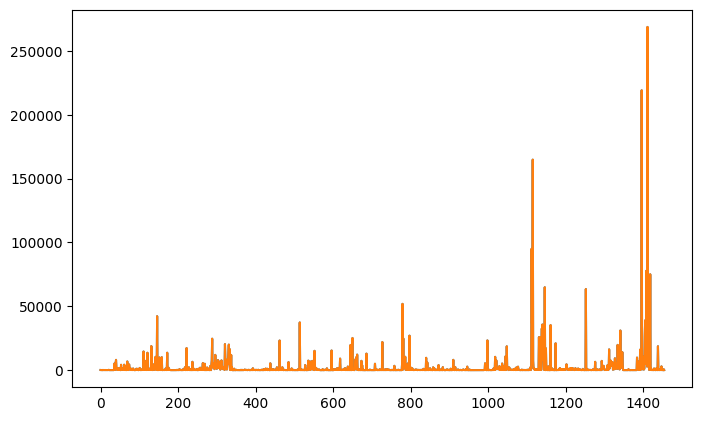

[]

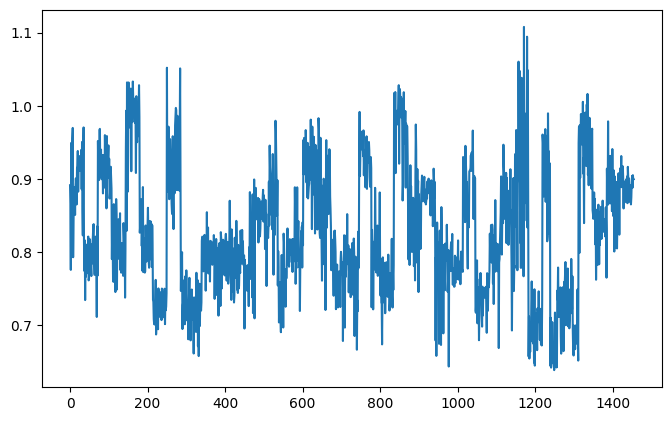

In [61]:
# PSD in range [0, 0.1] variation among different clips of all participants
validFeatures = []
for feature in featuresArray[:, -4]:
    if feature != NaN:
        validFeatures.append(feature)
plt.plot(validFeatures)
plt.plot(validFeatures)
plt.show()

# IBI mean variation among different clips of all participants
validFeatures = []
for feature in featuresArray[:, 3]:
    if feature != NaN:
        validFeatures.append(feature)
plt.plot(validFeatures)
plt.plot()



### 1.2 EMO
Text explanations can go here or in between python cells in the following parts

In [40]:
# Answers for facial movement processing task 

### 1.3 EDA

#### a) Power Spectral Distribution
We obtain the PSD of the GSR signal with the same method used above for the ECG signal, keeping the same parameters for the Welch implementation. 

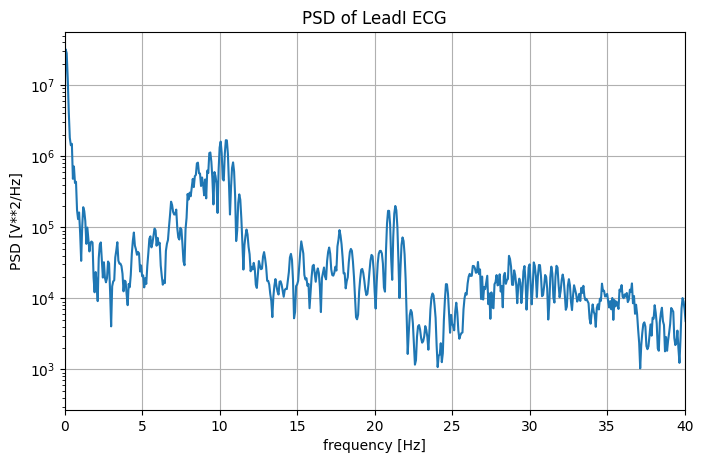

In [55]:
# we want the power spectral desity of the EDA signal of the second participant watching clip 1
with open("ex2_recordings/participant_02.pkl", "rb") as f:
    participant_02_data = pickle.load(f)

#Extract EDA data
GSR_freq = participant_02_data["FS_GSR"]
raw_GSR= np.array(participant_02_data["recordings"][1]["GSR"][:,1])

t = participant_02_data["recordings"][1]["GSR"][:,0]
t = t - t[0]

# Parameters for calculating the PSD 
# From [1] in exercise handout: Welch method using window length of 15xsr overlap 10xsr where sr denotes sampling rate
f, Pxx_den = signal.welch(x=raw_GSR, fs= GSR_freq, nperseg = 15*GSR_freq, noverlap= 10*GSR_freq, scaling='density', average='mean')

plt.semilogy(f, Pxx_den)
plt.xlim(0,40)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title('PSD of LeadI ECG')
plt.grid(True)
plt.show()

#### b) Filtering
THe power spectrum indicates that the most significant part of the signal is concentrated in the low frequencies which is expected from what is known of the GSR signal. GSR is a slow signal with a tonic component [0-0.16Hz] and a phasic component [0.16-2.4Hz] as mentioned in [2]. We cna therefore use a low pass filter at 2.4Hz cutoff to retain only the useful part of the GSR signal. 

A simple low pass filter however does not eliminate very fast and high amplitude artifacts that can be noticed in the raw GSR plots of some participants. Therefore we add a prefiltering step on teh signal derivative. After applyinf  25Hz low pass filter to the derivative, replacing all derivative values above or below a threshold by a random variable sampled from a truncated normal dristibution mirroring the inherent noise of the derivative signal. The values fo teh thresholds and low pass filter cutoff were determined empirically. (find source?)

Sources: 


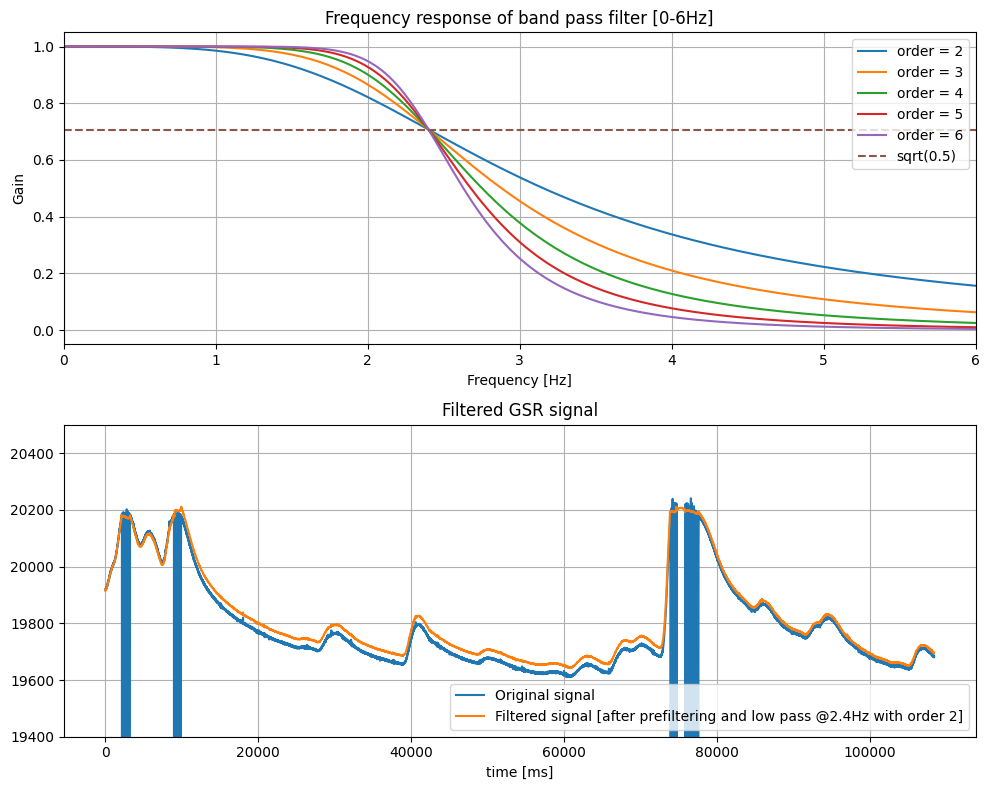

In [56]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    '''
    Function to simplify the application of truncnorm
    '''
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Define low pass filter functions
def butter_lowpass(lowcut,fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order,low, btype='low')
    return b, a

def butter_lowpass_filter(data, lowcut, fs, order):
    b, a = butter_lowpass(lowcut, fs, order)
    y = signal.filtfilt(b, a, data)
    return y

# Prefiltering 
def prefilter_gsr(raw_gsr, threshold):
    '''
    GSR prefiltering step on the signal derivative
    '''
    # Threshold the signal derivative
    derivative = np.diff(raw_gsr)
    filtered_derivative = derivative

    # Smoothe derivative using a low pass filter at 25Hz
    filtered_derivative = butter_lowpass_filter(filtered_derivative,25, GSR_freq, order)

    # Replace sections that are above the threshold by a random variable from a truncated normal distribution
    N = get_truncated_normal(mean = 0, sd = 0.5,low= -1 , upp = 1)
    mask1 = filtered_derivative>threshold
    mask2= filtered_derivative<-threshold
    mask = mask1+mask2
    c = np.count_nonzero(mask)
    fillers = N.rvs(c)
    filtered_derivative[mask]= fillers
    
    # reconstruct the pre-filtered GSR signal
    prefiltered_GSR = np.concatenate(([raw_gsr[0]], filtered_derivative)).cumsum()
    
    return prefiltered_GSR 

# Low pass filter implementation
# Parameters
lowcut = 2.4
fs = GSR_freq

# Plot the frequency response for a few different orders.
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10, 8), sharex=False)

for order in [2,3,4,5,6]:
    b, a = butter_lowpass(lowcut, fs, order=order)
    w, h = signal.freqz(b, a, worN=2000)
    ax[0].plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" %order)

ax[0].plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_xlim(0,6)
ax[0].set_ylabel('Gain')
ax[0].grid(True)
ax[0].set_title('Frequency response of band pass filter [0-6Hz]') 
ax[0].legend(loc='upper right')

# Choose filter order
order = 2
prefilter_threshold= 20

# Apply prefilter
prefiltered_gsr = prefilter_gsr(raw_GSR, prefilter_threshold)

# Apply low pass filer 
filtered_gsr = butter_lowpass_filter(prefiltered_gsr,lowcut, fs, order)

# Plot the first 5s of the filtered signal in time domain
ax[1].plot(t, raw_GSR, label='Original signal')
# ax[1].plot(prefiltered_gsr, label='Prefiltered signal')
ax[1].plot(t, prefiltered_gsr, label='Filtered signal [after prefiltering and low pass @2.4Hz with order %d]' %order)
ax[1].set_xlabel('time [ms]')
ax[1].set_ylim(19400, 20500)
ax[1].grid(True)
ax[1].set_title('Filtered GSR signal') 
ax[1].legend(loc='lower right')
plt.tight_layout()
plt.show()

#### c-d) Feature extraction

Base features; base features were extracted following the methods indicated in the ASCERTAIN, DECAF ans DEAP database papers (TODO: cite them)

Additional features:
From additional reading we know the GSR signal can be further decomposed into two components:
* A very low frequency tonic component that represents the slow shifts in a person's base skin conductance levels, usually due to factors such as external temperature, humidity or build up of sweat etc. 
* A phasic component that reflects more abrupt changes in skin conductance in nresponse to emotions (sympathetic nervous system)
As suggested in litterature [], we can extract features from the phaisc component of the signal directly 

Commonly extracted features in litterature include:
* The average amplitude of the SCR peak in the phasic signal (peak height - onset height) : shows the amplitude of the emotional response
* The average rise time of an SCR peak in the phasic signal: speed of the response
* The half recovery time of the SCR: gives an idea of the recovery rate 
* Area under hte curve for phasic componenent
* The mean of the tonic component: undestanding of the base skin response

> Warning: cvxEDA for separation of phasic and tonic components is slow. This cell takes ~ 15min to run


In [100]:
import neurokit2 as nk

pbar = tqdm(range(1455))

# Store statistics
n_features = 32 # 15 + 3 (feature 9) + 9 (feature 15) + 5 additional features

# Array shape: Participant_ID, Clip, features
EDA_features = np.zeros((0,2+n_features))

# Filter parameters
order = 2
prefilter_threshold= 20

clip_ids=participant_data["recordings"].keys()

# Load EDA data
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)

        # Extract sampling frequency of EDA
        fs = participant_data["FS_GSR"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract EDA for each clip 
        for clip in clip_ids:
            feature_vector = np.zeros((1, 2+n_features))
            
            feature_vector[0,0]=i+1 # Participant number
            feature_vector[0,1]=clip # clip number

            raw_gsr= np.array(participant_data["recordings"][clip]["GSR"][:,1])

            t = participant_data["recordings"][clip]["GSR"][:,0]
            t = t - t[0]
            
            # Apply prefilter
            prefiltered_gsr = prefilter_gsr(raw_gsr, prefilter_threshold)

            # Apply low pass filter 
            filtered_gsr = butter_lowpass_filter(prefiltered_gsr,lowcut, fs, order)

            # Truncate the signal to look at only the last 50s of the signal
            filtered_gsr_50s= filtered_gsr[-(50*fs):] 
            t = t[-(50*fs):]
            t = t-t[0]

            first_derivative = np.diff(filtered_gsr_50s)

            # 01: mean skin resistance
            feature_vector[0,2] = np.mean(filtered_gsr_50s)
            
            # 02: mean of first derivatives of skin resistance
            feature_vector[0,3] = np.mean(first_derivative)
            
            # 03: mean of absolute values of first derivatives of skin resistance
            feature_vector[0,4] = np.mean(np.abs(first_derivative))
            
            # 04: mean first derivative for negative values only
            feature_vector[0,5] = np.mean(first_derivative[first_derivative<0])

            # 05: percentage of time with negative first derivative
            feature_vector[0,6] = 100.0*(len(first_derivative[first_derivative<0])/len(first_derivative))
            
            # 06: standard deviation of skin resistance
            feature_vector[0,7] = np.std(filtered_gsr_50s)

            # 07: number of local minima in the skin conductance signal
            skin_cond = 1/filtered_gsr_50s
            feature_vector[0,8] = len(signal.argrelmin(skin_cond, order = 100)[0])

            # 08: average rising time of the GSR signal > time the derivative is positive
            feature_vector[0,9] = len(first_derivative[first_derivative>0])/fs
            
            # 09: power density estimates; 4 sub-bands in the [0-0.4] Hz band
            fr, Pxx_den = signal.welch(x=filtered_gsr_50s, fs= fs, nperseg = 15*fs, noverlap= 10*fs, scaling='density', average='mean')
            
            # W1: [0,0.1Hz) window
            feature_vector[0,10] = np.mean(Pxx_den[np.logical_and(fr>=0,fr<0.1)])
            
            # W2: [0.1,0.2Hz) window
            feature_vector[0,11] = np.mean(Pxx_den[np.logical_and(fr>=0.1,fr<0.2)])
            
            # W3: [0.2,0.3Hz) window
            feature_vector[0,12] = np.mean(Pxx_den[np.logical_and(fr>=0.2,fr<0.3)])

            # W4: [0.3,0.4Hz] window
            feature_vector[0,13] = np.mean(Pxx_den[np.logical_and(fr>=0.3 , fr<=0.4)])
            
            # 10: standard deviation of skin conductance
            feature_vector[0,14] = np.std(skin_cond)
            
            # 11: mean of first derivatives of skin conductance
            d_skin_cond = np.diff(skin_cond)
            feature_vector[0,15] = np.std(d_skin_cond)

            # 12: mean of absolute values of first derivatives of skin conductance
            feature_vector[0,16] = np.mean(np.abs(d_skin_cond))
            
            # 13: mean of absolute values of second derivatives of skin conductance
            feature_vector[0,17] = np.mean(np.abs(np.diff(d_skin_cond)))
            
            # 14: number of local minima in the skin resistance signal
            feature_vector[0,18] = len(signal.argrelmin(filtered_gsr_50s, order = 100)[0])

            # 15: log power density estimates; 10 sub-bands in the [0-2.4] Hz band
            log_psd = np.log(Pxx_den)
            # W1: [0,0.24Hz)
            feature_vector[0,19] = np.mean(log_psd[np.logical_and(fr>=0,fr<0.24)])
            
            # W2: [0.24,0.48Hz)
            feature_vector[0,20] = np.mean(log_psd[np.logical_and(fr>=0.24,fr<0.48)])

            # W3: [0.48,0.72Hz)
            feature_vector[0,21]= np.mean(log_psd[np.logical_and(fr>=0.48,fr<0.72)])

            # W4: [0.72,0.96Hz)
            feature_vector[0,22]= np.mean(log_psd[np.logical_and(fr>=0.72,fr<0.96)])

            # W5: [0.96,1.2Hz)
            feature_vector[0,23] = np.mean(log_psd[np.logical_and(fr>=0.96,fr<1.2)])

            # W6: [1.2,1.44Hz)
            feature_vector[0,24]= np.mean(log_psd[np.logical_and(fr>=1.2,fr<1.44)])
            
            # W7: [1.44,1.68Hz)
            feature_vector[0,25] = np.mean(log_psd[np.logical_and(fr>=1.44,fr<1.68)])
            
            # W8: [1.68,1.92Hz)
            feature_vector[0,26] = np.mean(log_psd[np.logical_and(fr>=1.68,fr<1.92)])
            
            # W9: [1.92,2.16Hz)
            feature_vector[0,27] = np.mean(log_psd[np.logical_and(fr>=1.92,fr<2.16)])
            
            # W10:[2.16,2.4Hz)
            feature_vector[0,28] = np.mean(log_psd[np.logical_and(fr>=2.16,fr<2.4)])

            # Additional features
            # Normalise the signal: 
            filt_gsr_norm = (filtered_gsr_50s - filtered_gsr_50s.mean()) / filtered_gsr_50s.std()
            
            # Decompose the signal in phasic and tonic components - cvxEDA method from Neurokit 2 library
            signals= eda_phasic(filt_gsr_norm, sampling_rate=fs, method="cvxeda")
            phasic = signals['EDA_Phasic'].values
            tonic = signals['EDA_Tonic'].values

            # Get phasic component features using standard neurokit 2 library algorithm
            _, features = eda_peaks(phasic,sampling_rate=fs,  method="neurokit", amplitude_min=0.05)

            # Additional feature 1: average peak amplitude (= peak heigh - onset height)
            amplitude = features["SCR_Amplitude"]
            amplitude = amplitude[amplitude>0.1] # amplitude too small means the algorithm misdetected something
            
            if amplitude.size ==0: # if the amplitude array is empty
                feature_vector[0,29] = 0
            else : 
                feature_vector[0,29] = np.mean(amplitude)

            # Additional feature 2: average rise time (time between onset and peak)
            rise_time = features["SCR_RiseTime"]
            rise_time = rise_time[rise_time>0.5] # rising too fast means the detected peaks might be wrong
            
            if rise_time.size ==0: # if the rise_time array is empty
                feature_vector[0,30] = 0
            else : 
                feature_vector[0,30] = np.mean(rise_time)

            # Additional feature 3: average recovery time (time of decay from peak to 1/2 amplitude)
            
            recovery_time = features["SCR_RecoveryTime"]
            recovery_time = recovery_time[recovery_time>0.5]

            if recovery_time.size ==0: # if the amplitude array is empty
                feature_vector[0,31] = 0
            else : 
                feature_vector[0,31] = np.mean(recovery_time)

            # Additional feature 4: Area under the curve
            AUC_phasic = np.sum(phasic*(1/fs))
            feature_vector[0,32] = AUC_phasic

            # Additional feature 5: mean tonic signal 
            feature_vector[0,33] = np.mean(tonic)

            # Stack feature vector in data matrix
            EDA_features = np.vstack((EDA_features, feature_vector))
            pbar.update(1)
            



  0%|          | 0/1455 [00:00<?, ?it/s]

### 1.4 Valence and arousal
#### a) Pearson correlation coefficient
We use scipy.stats implementation of the pearson correlation coefficient

In [50]:
# We need to calculate the Pearson correlation coefficient between valence and arousal for all participants and clips in the dataset
valence= np.zeros((0,1))
arousal= np.zeros((0,1))

for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)
        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            v = np.array(participant_data["recordings"][clip]["valence"]).reshape(1,-1)
            a = np.array(participant_data["recordings"][clip]["arousal"]).reshape(1,-1)

            valence = np.vstack((valence, v))
            arousal = np.vstack((arousal, a))

pearson_coeff, p_val=pearsonr(np.concatenate(valence),np.concatenate(arousal))
print("The pearson correlation coefficient between valence and arousal:{:.4f}".format(pearson_coeff))


The pearson correlation coefficient between valence and arousal:-0.0177


**Interpretation:**
 
The pearson coefficient is very close to the zero, which means there is no linear correlation between sel reported valence and arousal. That means the valence and arousal ratings can be used as wo separate dimensions to evaluate the emotional state of the participant. 

#### b) Distribution

[[ 1.]
 [-1.]
 [ 1.]
 ...
 [-3.]
 [-1.]
 [-2.]]
[0 1] [784 671]


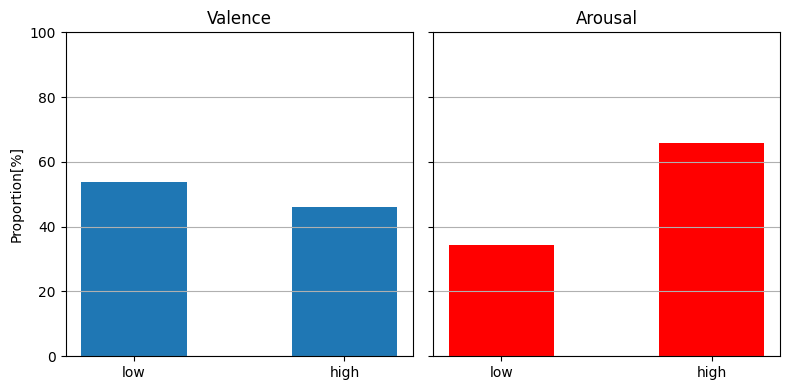

In [51]:

valence_dist = (valence>0).astype(int)
arousal_dist = (arousal>3).astype(int)

v_class, v_counts = np.unique(valence_dist, return_counts=True)
a_class, a_counts = np.unique(arousal_dist, return_counts=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8, 4), sharey=True)

ax[0].bar(v_class, 100*v_counts/np.sum(v_counts), 0.5, tick_label=['low','high'])
ax[0].set_ylim(0,100)
ax[0].set_title('Valence')
ax[0].set_ylabel('Proportion[%]')
ax[0].grid(axis='y')
ax[1].bar(a_class,100*a_counts/np.sum(a_counts),0.5, tick_label=['low','high'],color='red')
ax[1].set_title('Arousal')
ax[1].grid(axis='y')
plt.tight_layout()

plt.show()

**Discussion:**
 
The class distribution plot shows that while the Valence dataset seems roughly balanced between ```high``` and ```low``` instances, the Arousal dataset is imbalanced, with ```high``` Arousal recordings being more represented than low Arousal ones. This might need to be taken into account when training the Classifier. 


## 2. Classification 

### Random Forest Classifier

#### a) Data loading and preprocessing
In a first step we look into the feature data and make it can be used to train the classifier: it doesn't contain any ```nan``` or ```inf``` values 
* ECG data:
* EMO data:
* EDA data: potential issues are tackled directly in the feature extraction section  
* EEG data: we test different imputation strategies: mean, median, zero and choose the one leading to the best results in classification

In [124]:
# Data imputation functions
def impute_mean(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=np.mean(feature[np.isfinite(feature)]), posinf = np.mean(feature[np.isfinite(feature)]), neginf = np.mean(feature[np.isfinite(feature)]))
    return data

def impute_median(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=np.median(feature[np.isfinite(feature)]), posinf = np.median(feature[np.isfinite(feature)]), neginf = np.median(feature[np.isfinite(feature)]))
    return data

def impute_zero(data):
    for feature in data.T: # check column by column:
        feature = np.nan_to_num(x=feature,copy=False, nan=0, posinf = 0, neginf=0)
    return data

# Load features
n_eeg_features = 88
EEG_features = np.zeros((0, 2 + n_eeg_features))

# Load EEG features
for i in range(44):
    if i<9:
        pn = "0"+str(i+1)
    else: 
        pn= str(i+1) 
    with open("ex2_recordings/participant_%s.pkl" %pn, "rb") as f:
        participant_data = pickle.load(f)
        # Extract sampling frequency of EEG
        fs_EEG = participant_data["FS_EEG"]

        # Clips
        clip_ids=participant_data["recordings"].keys()
        # Extract ECG for each clip 
        for clip in clip_ids:
            feature_vector = np.zeros((1, 2+n_eeg_features))
            
            feature_vector[0,0]=i+1 # Participant number
            feature_vector[0,1]=clip # clip number

            feature_vector[0,2:2+n_eeg_features]=participant_data["recordings"][clip]["EEG_features"]
            EEG_features = np.vstack((EEG_features, feature_vector))

# Impute data
EEG_features = impute_mean(EEG_features)

# Combine into a single dataset
n_ecg_features = 32
n_emo_features = 72
n_eda_features = 32

n_features = 2 + n_eda_features + n_eeg_features #+ n_ecg_features + n_emo_features

all_features = np.zeros((0,n_features))
# Columns: patient ID, clip# , ECG features (32), EMO features (72), EDA features (32), EEG features (88)
all_features=np.hstack((EDA_features, EEG_features[:,2:]))

print("Feature Data Ready")

#### b) Classifier training and cross validation

Using LeaveOneGroupOut class from scikit learn library we can split the dataset into groups, groups being defined by clip number for leave one clip out validation and by participan ID for leave participant cross validation. 
Evaluation metrics are averaged for each cross validation scheme before being printed out. 

> Note: this cells runs in around 3 minutes

TODO : tune the classifier 

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Check data has finite values and is in the correct format 
assert all_features.shape[0] == 1455 , "Feature array has wrong dimensions (axis 0)"
assert all_features.shape[1] == n_features , "Feature array has wrong dimensions (axis 1)"
assert len(valence_dist) == len(arousal_dist) , "Dimensions of label arrays don't match"
assert all_features.shape[0]== len(valence_dist), " Label array dimension doesn't match feature array dimension"

assert np.sum(np.isnan(all_features).astype(int)) == 0, 'Feature array contains NaN values' 
assert np.sum(np.isnan(valence_dist).astype(int)) == 0, 'Valence array contains Nan values'
assert np.sum(np.isnan(arousal_dist).astype(int)) == 0, 'Arousal array contains Nan values'

# Timer
tic = time.time()

# All data
data = all_features[:,2:]

# Labels
valence_labels = valence_dist
arousal_labels = arousal_dist

# Groups for Leave one out validation
group_clips = all_features[:,1]
group_participants = all_features[:,0]

# Leave one clip out cross-validation 
leave_clip_out = LeaveOneGroupOut()
# Leave one participant out cross-validation 
leave_participant_out = LeaveOneGroupOut()


print("VALENCE CLASSFIER")
print("=================")
print()

print("Running one clip out cross validation ...")

# Reset metrics:
f1 = np.zeros((0,1)) 
precision = np.zeros((0,1))
accuracy = np.zeros((0,1)) 
recall = np.zeros((0,1))
confusion_m1= np.zeros((2,2))

for train_idx, test_idx in leave_clip_out.split(X=data, y=valence_labels, groups=group_clips):
    
    # Train - test split
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = valence_labels[train_idx], valence_labels[test_idx]
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # evaluate model
    y_pred = model.predict(X_test)

    f1 = np.append(f1, f1_score(y_test, y_pred))
    precision = np.append(precision, precision_score(y_test, y_pred))
    accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
    recall = np.append(recall, recall_score(y_test, y_pred))
    confusion_m1 += confusion_matrix(y_test, y_pred, labels = model.classes_)

valence_loco_metrics = np.array([np.mean(f1), np.mean(precision), np.mean(accuracy), np.mean(recall)])
print("Finsihed one clip out cross validation")
print()
print("F1 score: {:.2f}".format(valence_loco_metrics[0]))
print("Precision score: {:.2f}".format(valence_loco_metrics[1]))
print("Accuracy score: {:.2f}".format(valence_loco_metrics[2]))
print("Recall score: {:.2f}".format(valence_loco_metrics[3]))
# print("Confusion matrix:")
# print(confusion_m1)
print()

# print("Running one participant out cross validation...")

# Reset metrics:
f1 = np.zeros((0,1)) 
precision = np.zeros((0,1))
accuracy = np.zeros((0,1)) 
recall = np.zeros((0,1))
confusion_m2 = np.zeros((2,2))


for train_idx, test_idx in leave_participant_out.split(X=data, y=valence_labels, groups=group_participants):
    
    # Train - test split
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = valence_labels[train_idx], valence_labels[test_idx]
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # evaluate model
    y_pred = model.predict(X_test)

    f1 = np.append(f1, f1_score(y_test, y_pred))
    precision = np.append(precision, precision_score(y_test, y_pred))
    accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
    recall = np.append(recall, recall_score(y_test, y_pred))
    confusion_m2 += confusion_matrix(y_test, y_pred)

valence_lopo_metrics = np.array([np.mean(f1), np.mean(precision), np.mean(accuracy), np.mean(recall)])
print("Finsihed one participant out cross validation")
print()
print("F1 score: {:.2f}".format(valence_lopo_metrics[0]))
print("Precision score: {:.2f}".format(valence_lopo_metrics[1]))
print("Accuracy score: {:.2f}".format(valence_lopo_metrics[2]))
print("Recall score: {:.2f}".format(valence_lopo_metrics[3]))
# print("Confusion matrix:")
# print(confusion_m2)
print()

print("AROUSAL CLASSFIER")
print("=================")
print()

print("Running one clip out cross validation ...")

# Reset metrics
f1 = np.zeros((0,1)) 
precision = np.zeros((0,1))
accuracy = np.zeros((0,1)) 
recall = np.zeros((0,1))
confusion_m3 = np.zeros((2,2))

for train_idx, test_idx in leave_clip_out.split(X=data, y=arousal_labels, groups=group_clips):
    
    # Train - test split
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = valence_labels[train_idx], valence_labels[test_idx]
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # evaluate model
    y_pred = model.predict(X_test)

    f1 = np.append(f1, f1_score(y_test, y_pred))
    precision = np.append(precision, precision_score(y_test, y_pred))
    accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
    recall = np.append(recall, recall_score(y_test, y_pred))
    confusion_m3 += confusion_matrix(y_test, y_pred)

arousal_loco_metrics = np.array([np.mean(f1), np.mean(precision), np.mean(accuracy), np.mean(recall)])
print("Finsihed one clip out cross validation")
print()
print("F1 score: {:.2f}".format(arousal_loco_metrics[0]))
print("Precision score: {:.2f}".format(arousal_loco_metrics[1]))
print("Accuracy score: {:.2f}".format(arousal_loco_metrics[2]))
print("Recall score: {:.2f}".format(arousal_loco_metrics[3]))
print()

print("Running one participant out cross validation...")
# Reset metrics:
f1 = np.zeros((0,1)) 
precision = np.zeros((0,1))
accuracy = np.zeros((0,1)) 
recall = np.zeros((0,1))
confusion_m4 = np.zeros((2,2))

for train_idx, test_idx in leave_participant_out.split(X=data, y=arousal_labels, groups=group_participants):
    
    # Train - test split
    X_train, X_test = data[train_idx], data[test_idx]
    y_train, y_test = valence_labels[train_idx], valence_labels[test_idx]
    
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # evaluate model
    y_pred = model.predict(X_test)

    f1 = np.append(f1, f1_score(y_test, y_pred))
    precision = np.append(precision, precision_score(y_test, y_pred))
    accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
    recall = np.append(recall, recall_score(y_test, y_pred))
    confusion_m4 += confusion_matrix(y_test, y_pred)

arousal_lopo_metrics = np.array([np.mean(f1), np.mean(precision), np.mean(accuracy), np.mean(recall)])
print("Finsihed one participant out cross validation")
print()
print("F1 score: {:.2f}".format(arousal_lopo_metrics[0]))
print("Precision score: {:.2f}".format(arousal_lopo_metrics[1]))
print("Accuracy score: {:.2f}".format(arousal_lopo_metrics[2]))
print("Recall score: {:.2f}".format(arousal_lopo_metrics[3]))
print()

print("Time elapsed: {:.2f}".format(time.time()-tic))



VALENCE CLASSFIER

Running one clip out cross validation ...
Finsihed one clip out cross validation

F1 score: 0.32
Precision score: 0.50
Accuracy score: 0.52
Recall score: 0.42

Finsihed one participant out cross validation

F1 score: 0.37
Precision score: 0.48
Accuracy score: 0.53
Recall score: 0.34

AROUSAL CLASSFIER

Running one clip out cross validation ...
Finsihed one clip out cross validation

F1 score: 0.32
Precision score: 0.48
Accuracy score: 0.52
Recall score: 0.38

Running one participant out cross validation...
Finsihed one participant out cross validation

F1 score: 0.36
Precision score: 0.48
Accuracy score: 0.53
Recall score: 0.34

Time elapsed: 141.76


#### C) Confusion matrices

Plots the combined confusion matrices calculated in the cell above 

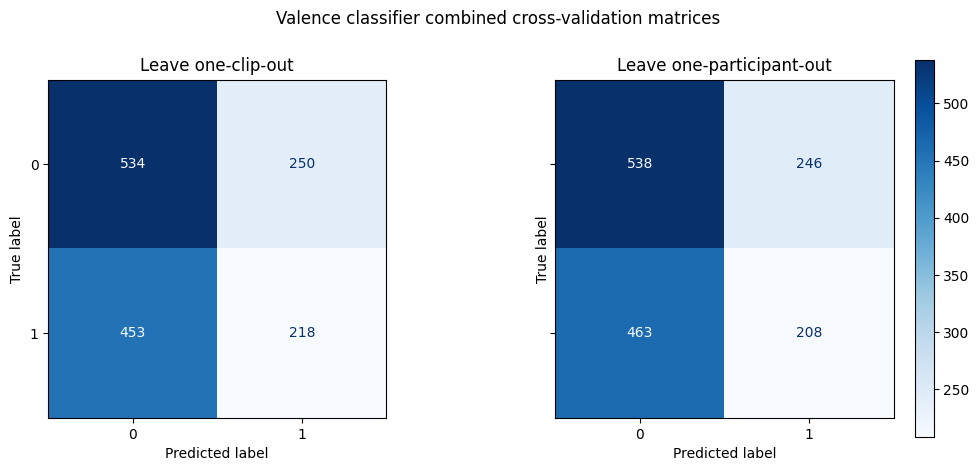

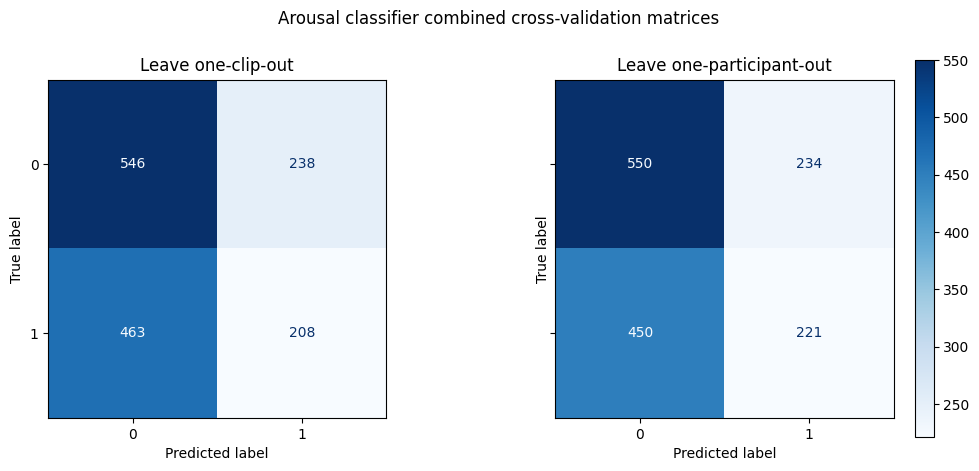

In [169]:
# Function for plotting confusion matrices for a classifier
def plot_confusion_matrices(cm_clip_out, cm_participant_out, title, normalize=False):
    # Create figure with subplots
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12, 5), sharey=True)
    
    # Overall title
    plt.suptitle(title)

    # Display confusion matrix for leave one clip out
    if normalize:
        disp = ConfusionMatrixDisplay(cm_clip_out/np.sum(cm_clip_out))
        disp.plot(ax=ax[0], values_format =".2f" , cmap="Blues") 
    else: 
        disp = ConfusionMatrixDisplay(cm_clip_out)
        disp.plot(ax=ax[0], values_format =".0f" , cmap="Blues") 
    disp.ax_.set_title("Leave one-clip-out")
    disp.im_.colorbar.remove()

    # Display confusion matrix for leave one participant out 
    if normalize: 
        disp = ConfusionMatrixDisplay(cm_participant_out/np.sum(cm_participant_out))
        disp.plot(ax=ax[1],values_format =".2f" , cmap="Blues")
    else: 
        disp = ConfusionMatrixDisplay(cm_participant_out)
        disp.plot(ax=ax[1], values_format =".0f" , cmap="Blues") 
    disp.ax_.set_title("Leave one-participant-out")
    plt.show()

# For the valence classifier
title = "Valence classifier combined cross-validation matrices"
plot_confusion_matrices(confusion_m1, confusion_m2, title, normalize=False)

# For the arousal classifier
title = "Arousal classifier combined cross-validation matrices"
plot_confusion_matrices(confusion_m3, confusion_m4, title, normalize=False)




#### d) Selecting the top 10 features

TODO: loopk up how to choose the 10 features

#### e) Zero Rule baseline comparison

The Zero Rule algorithm always predicts the majority class in the dataset. If we want a direct comparison between the metrics of our classifier and the ZeroR algorithm, we need to apply the ZeroR algorithm in the same cross validation scheme and compare average metrics. 

In [185]:
# Functions to apply ZeroR algorithm 

def zero_rule_classification(y_train, test):
    '''
    Finds majority label and applies it as prediction to a test set
    '''
    # Find the majority label
    label, counts = np.unique(y_train, return_counts=True)
    maj_label = label[np.argmax(counts)]
    
    # Apply prediction
    y_pred = maj_label*np.ones(len(test))

    return y_pred.astype(int)

def zero_rule_cv(data, labels, cross_val_scheme, group):
    '''
    Applies ZeroR alogorithm to a group cross validation scheme
    '''
    
    # Reset metrics:
    f1 = np.zeros((0,1)) 
    precision = np.zeros((0,1))
    accuracy = np.zeros((0,1)) 
    recall = np.zeros((0,1))
    confusion_m= np.zeros((2,2))

    for train_idx, test_idx in cross_val_scheme.split(X=data, y=labels, groups=group):
    
        # Train - test split
        X_train, X_test = data[train_idx], data[test_idx]
        y_train, y_test = valence_labels[train_idx], valence_labels[test_idx]

        # Prediction
        y_pred = zero_rule_classification(y_train, X_test)

        # Metrics
        f1 = np.append(f1, f1_score(y_test, y_pred))
        precision = np.append(precision, precision_score(y_test, y_pred))
        accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))
        recall = np.append(recall, recall_score(y_test, y_pred))
        confusion_m += confusion_matrix(y_test, y_pred)
    
    # Average metrics 
    f1 = np.mean(f1)
    precision =  np.mean(precision)
    accuracy = np.mean(accuracy)
    recall =  np.mean(recall)

    metrics = np.array([f1, precision, accuracy, recall]) 

    return metrics, confusion_m

# All data
data = all_features[:,2:]

# Labels
valence_labels = valence_dist
arousal_labels = arousal_dist

# Groups for Leave one out validation
group_clips = all_features[:,1]
group_participants = all_features[:,0]

# Leave one clip out cross-validation 
leave_clip_out = LeaveOneGroupOut()
# Leave one participant out cross-validation 
leave_participant_out = LeaveOneGroupOut()

print("VALENCE ZERO-R CLASSFIER")
print("=================")
print()

# leave clip out
valence_loco_metrics_zr, valence_loco_cm_zr  = zero_rule_cv(data, valence_labels, leave_clip_out, group_clips) 
# leave participant out 
valence_lopo_metrics_zr, valence_lopo_cm_zr  = zero_rule_cv(data, valence_labels, leave_participant_out, group_participants) 

print("AROUSAL ZERO-R CLASSFIER")
print("=================")
print()
# leave clip out
arousal_loco_metrics_zr, valence_loco_cm_zr  = zero_rule_cv(data, arousal_labels, leave_clip_out, group_clips) 
# leave participant out 
arousal_lopo_metrics_zr, valence_lopo_cm_zr  = zero_rule_cv(data, arousal_labels, leave_participant_out, group_participants) 







VALENCE ZERO-R CLASSFIER

AROUSAL ZERO-R CLASSFIER

